# Basic Tutorial For Using the Dataset

In [1]:
# Import the Data
import base_dataset as dataset

# Import other packages needed for this tutorial.
import torchvision
import IPython
import torch
from collections import OrderedDict
#from torchvision import transforms
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image
import gc

In [2]:
torch.__version__
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

### Set up the Dataset
- Define the path to your dataset folder and the path to your annotation json file. 
- Note: my directory definition may be different from yours.

In [3]:
train_dir = "data_2c/train"
train_coco = "data/annotations/train.json"

val_dir = "data_2c/val"
val_coco = "data/annotations/val.json"

test_dir = "data_2c/test"
test_coco = "data/annotations/test.json"

# Note other transformations are not implemented as of this moment.
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        #transforms.append(T.RandomRotation(degrees=(-180, 180)))
        #transforms.append(T.RandomResizedCrop(size=(450, 450), scale=(0.25, 2.6)))
    #transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    transforms.append(T.ToDtype(torch.float, scale=True))
    #transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

# Define the dataset class
train_dataset = dataset.RadioGalaxyNET(root=train_dir,
                          annFile=train_coco,
                          transforms=get_transform(train=True)
                          ) 

val_dataset = dataset.RadioGalaxyNET(root=val_dir,
                          annFile=val_coco,
                          transforms=get_transform(train=False)
                          ) 

test_dataset = dataset.RadioGalaxyNET(root=test_dir,
                          annFile=test_coco,
                          transforms=get_transform(train=False)
                          ) 

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Visualize Data

In [4]:
# You can check for the Categorical definition here. 
train_dataset.display_categories()

id 1: FR-II
id 2: FR-I
id 3: FR-X
id 4: R


### Training

#### Define Dataloader

In [4]:
# Device Selection
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# collate_fn needs for batch
'''
def collate_fn(batch):
    images = []
    annotations = []
    for img, ann in batch:
        images.append(img)
        annotations.append(ann)
    return images, annotations
'''

def collate_fn(batch):
    return tuple(zip(*batch))
# Batch size
train_batch_size = 32

# Define DataLoader for some reason my dataloader can only be = 0, please try different number and let me know how you guys goes. 
data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          num_workers=0,
                                          collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          num_workers=0,
                                          collate_fn=collate_fn)

cuda


In [6]:
#dino_resnet50_pretrain_full_checkpoint
#heckpoint_raw = torch.load('dino_resnet50_pretrain_full_checkpoint.pth')
#checkpoint_raw

#### Define Model

- I followed the tutorial set out here for Fast RCNN: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_model_instance_segmentation(num_classes,
                                    backbone_checkpoint_path = None, 
                                    pretrained = False,
                                    freeze_backbone = False,
                                    mode = 'student'):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # Loading the weights of imageNet if backbone is not provided
    if pretrained == True:
        # Load only backbone weights from the checkpoint if provided
        if backbone_checkpoint_path:
            checkpoint_raw = torch.load(backbone_checkpoint_path)
            if 'model' in checkpoint_raw:
                checkpoint = checkpoint_raw['model']
            else:
                checkpoint = checkpoint_raw
            #checkpoint = checkpoint_raw['model']
            new_state_dict = OrderedDict()

            # Modify key mappings
            for key, value in checkpoint.items():
                if 'C' not in key:
                    if mode == 'student':
                        if 'teacher' not in key:  # Filter out keys related to the teacher
                            new_key = key.replace('student.0.encoder.', '')  # Adjust the prefix according to your checkpoint's structure
                            if 'mlp' not in new_key and 'last_layer' not in new_key:  # Exclude non-FPN layers
                                new_state_dict[new_key] = value
                    else:
                        if 'student' not in key:  # Filter out keys related to the teacher
                            new_key = key.replace('teacher.0.encoder.', '')  # Adjust the prefix according to your checkpoint's structure
                            if 'mlp' not in new_key and 'last_layer' not in new_key:  # Exclude non-FPN layers
                                new_state_dict[new_key] = value
            # Try loading the modified state dict into the model
            try:
                model.backbone.body.load_state_dict(new_state_dict, strict=True)
            except Exception as e:
                print(f"Error loading state dict: {e}")
        # Other cases
        else:
            backbone_pretrained = resnet_fpn_backbone('resnet50', pretrained=True)
            model.backbone.load_state_dict(backbone_pretrained.state_dict())
    if freeze_backbone == True:
        for param in model.backbone.parameters():
            param.requires_grad = False
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [8]:
# I believe Fast RCNN recognises background as a class.
num_classes = 5
num_epochs = 50
model = get_model_instance_segmentation(num_classes, 
                                        pretrained = True, 
                                        freeze_backbone = True,
                                        mode = 'teacher',
                                        backbone_checkpoint_path = 'dino_resnet50_pretrained.pth')
                                        #backbone_checkpoint_path = 
                                        #'dino_radio_pretraining_ft_pretrained_weights.pth') #ImageNet Weights
                                        #backbone_checkpoint_path = 'dino_radio_pretraining_5.pth') 
                                        #backbone_checkpoint_path= 'colab_dino_pretraining_4.pth') 
                                        #backbone_checkpoint_path = 'dino_pretraining_5.pth')

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
'''
optimizer = torch.optim.SGD(
    params,
    lr=0.0015,
    momentum=0.9,
    weight_decay=0.0005
)
'''
optimizer = torch.optim.Adam(
    params,
    lr=0.0015,
    betas=(0.9, 0.999),  # Default values for betas in Adam
    weight_decay=0.0005
)
len_dataloader = len(data_loader)

d:\Coding Applications\miniconda\envs\SAM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Coding Applications\miniconda\envs\SAM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Define the training iterations

-  This training loop is only for object detection

In [9]:
import os
from engine import train_one_epoch, evaluate


lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.9
)

loss_history_train = []
map50_history_bbox = []
map50_history_seg = []
#IOU
for epoch in range(num_epochs):
    if epoch < 20:
        save_path_loc = None
    else:
        save_path_loc = 'model_store'
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, save_path=save_path_loc, print_freq=10)
    # update the learning rate
    loss_iteration_train = metric_logger.meters['loss'].global_avg
    loss_history_train.append(loss_iteration_train)
    lr_scheduler.step()
    # evaluate on the test dataset
    del loss_iteration_train 
    del metric_logger  # Explicitly delete the object
    
    gc.collect()  
    
    coco_evaluator = evaluate(model, data_loader_val, device=device)
    bbox_set_train =[]
    segm_set_train =[]
    for iou_type, coco_eval in coco_evaluator.coco_eval.items():
        if iou_type == "bbox":
            bbox_set_train = coco_eval.stats
            map50_bbox = bbox_set_train[1]
            map50_history_bbox.append(map50_bbox)
        else:
            segm_set_train = coco_eval.stats
            map50_seg = segm_set_train[1]
            map50_history_seg.append(map50_seg)
    #coco_evaluator.detach()  # Perform any custom detach logic

    # Clear coco_evaluator after its last use
    del coco_evaluator  # Explicitly delete the object
    gc.collect()
    #gc.collect()

Epoch: [0]  [ 0/62]  eta: 0:02:51  lr: 0.000026  loss: 7.4382 (7.4382)  loss_classifier: 2.2756 (2.2756)  loss_box_reg: 0.0034 (0.0034)  loss_mask: 4.4862 (4.4862)  loss_objectness: 0.6604 (0.6604)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 2.7599  data: 0.0801  max mem: 9524
Epoch: [0]  [10/62]  eta: 0:00:46  lr: 0.000272  loss: 2.6701 (3.3640)  loss_classifier: 0.3276 (0.6879)  loss_box_reg: 0.0272 (0.0249)  loss_mask: 1.8535 (2.1952)  loss_objectness: 0.4482 (0.4437)  loss_rpn_box_reg: 0.0132 (0.0123)  time: 0.8981  data: 0.0662  max mem: 9752
Epoch: [0]  [20/62]  eta: 0:00:33  lr: 0.000517  loss: 1.2534 (2.2406)  loss_classifier: 0.3496 (0.5319)  loss_box_reg: 0.0424 (0.0394)  loss_mask: 0.6978 (1.3646)  loss_objectness: 0.1576 (0.2928)  loss_rpn_box_reg: 0.0112 (0.0118)  time: 0.6921  data: 0.0658  max mem: 9752
Epoch: [0]  [30/62]  eta: 0:00:24  lr: 0.000763  loss: 0.6770 (1.7056)  loss_classifier: 0.2080 (0.4141)  loss_box_reg: 0.0625 (0.0506)  loss_mask: 0.2996 (1.0033)  loss_ob

In [10]:
import pickle
with open('results/optium/Untrained/bbox_map50_untrained.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
ref_baseline = loaded_data['bbox_map50'][0:num_epochs]


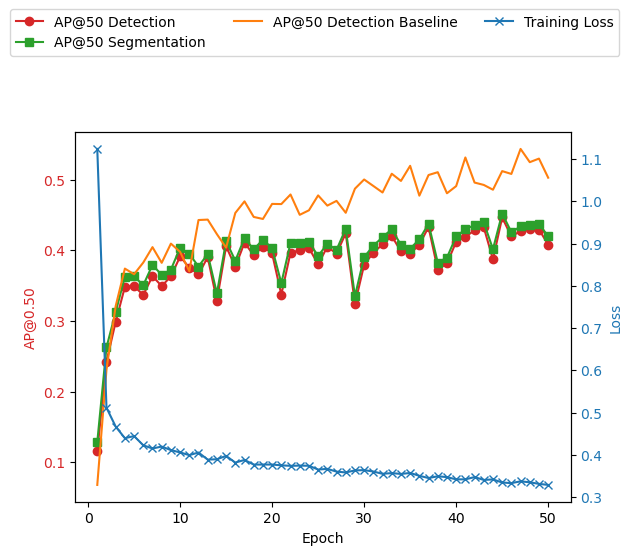

In [11]:
epochs = range(1, num_epochs+1)
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot mAP@0.50
ax1.plot(epochs, map50_history_bbox, color='tab:red', label='AP@50 Detection', marker='o')
ax1.plot(epochs, map50_history_seg, color='tab:green', label='AP@50 Segmentation', marker='s')
ax1.plot(epochs, ref_baseline, color = 'tab:orange', label='AP@50 Detection Baseline')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('AP@0.50', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
ax2.plot(epochs, loss_history_train, color='tab:blue', label='Training Loss', marker='x')
ax2.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')


# Add a legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.show()

In [12]:

data = {'bbox_map50': map50_history_bbox}
with open('results/optium/DINO_pretrained/bbox_map50_resnet_dino.pkl', 'wb') as file:
    pickle.dump(data, file)

#### Visualizing Results

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


'\n'

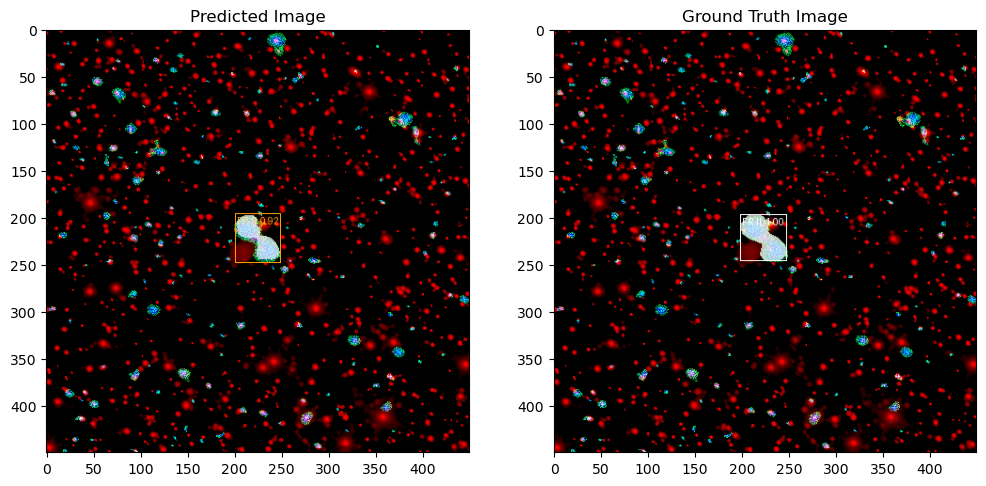

In [16]:
# Define an index
img_index = 7
# Define Testing Dataset
test_dir = "data/test"
test_coco = "data/annotations/test.json"

test_dataset = dataset.RadioGalaxyNET(root=test_dir,
                          annFile=test_coco,
                          transforms=get_transform(train=False)
                          ) 

# Format images for visualization

image = test_dataset.__getitem__(img_index)[0]
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
image_pred = test_dataset.__getitem__(img_index)[0].to(device)

# Set the model to evaluation mode
model_test.eval()
predictions =model_test([image_pred, ])

# Define classification and segmentation threshold
class_th = 0.4
segment_th = 0.7
idxToLabel = {1: 'FR-II', 2: 'FR-I', 3: 'FR-X', 4:'R'}

pred = predictions[0]

score_list = torch.nonzero(pred["scores"] > class_th)
pred_labels = []

# Prediction
i = 0
for item in pred['labels'][score_list]:
    class_name = idxToLabel[item.item()]
    class_score = pred["scores"][score_list[i]].item()
    class_score = format(class_score, ".2f")
    label_str = class_name + ": " + class_score
    pred_labels.append(label_str)
    i += 1

pred_boxes = pred["boxes"][score_list]
output_image = draw_bounding_boxes(image, pred_boxes[:,0], pred_labels, colors="orange")
masks = (pred["masks"][score_list] > 0.5).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks[0], alpha=0.7, colors="white")

# Ground Truth

__,g_truth = test_dataset.__getitem__(img_index)


i = 0
pred_labels_gt = []
for item in g_truth['labels']:
    class_name = idxToLabel[item.item()]
    class_score = 1.00
    class_score = format(class_score, ".2f")
    label_str = class_name + ": " + class_score
    pred_labels_gt.append(label_str)
    i += 1

pred_boxes_gt = g_truth["boxes"].long()

output_image_gt = draw_bounding_boxes(image, pred_boxes_gt, pred_labels_gt, colors="white")
masks_gt = (g_truth["masks"]>0).squeeze(1)
output_image_gt = draw_segmentation_masks(output_image_gt, masks_gt, alpha=0.7, colors="white")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(output_image.permute(1, 2, 0))
ax1.set_title('Predicted Image')
ax2.imshow(output_image_gt.permute(1, 2, 0))
ax2.set_title('Ground Truth Image')
"""
"""

### Testing

In [6]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def load_maskrcnn_model(weights_path, num_classes=None):
    """
    Load a Mask R-CNN model with custom weights and optionally adjust the predictor head.

    Parameters:
    - weights_path: str, path to the pretrained weights file.
    - num_classes: int, the number of classes (including the background). If None, use the default model's head.

    Returns:
    - model: Mask R-CNN model with loaded weights and adjusted head if num_classes is provided.
    """
    # Load the model without pretrained weights from torchvision
    model = maskrcnn_resnet50_fpn(pretrained=False)

    # If num_classes is provided, adjust the predictor heads
    if num_classes is not None:
        # Get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features

        # Replace the pre-trained head with a new one (for box classifier)
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # For the mask classifier, replace the mask predictor
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256  # Typically the same as in pretrained model
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    # Load the weights into the model
    model.load_state_dict(torch.load(weights_path), strict=False)

    return model



d:\Coding Applications\miniconda\envs\SAM\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Coding Applications\miniconda\envs\SAM\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
import torchmetrics
def evaluate_model(model, test_data_loader):
    """
    Evaluate the Mask R-CNN model on the test dataset using torchmetrics for mIoU and return mIoU and mAP metrics.

    Parameters:
    - model: The Mask R-CNN model.
    - test_data_loader: DataLoader for the test dataset.

    Returns:
    - mIoU: Mean Intersection over Union for the test dataset calculated using MulticlassJaccardIndex.
    - mAP: Mean Average Precision for the test dataset.
    """
    device = 'cuda'
    model.to(device)
    model.eval()

    # Initialize torchmetrics for mIoU and mAP calculation
    iou_metric = torchmetrics.JaccardIndex(num_classes=5, task="multiclass").to(device)  # Adjust num_classes as needed
    ap_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision().to('cuda')  

    with torch.no_grad():
        for images, targets in test_data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Compute masks as needed for IoU calculation
                gt_masks = targets[i]['masks'].to(device)
                #.to(device)  # Ground truth masks
                pred_masks = output['masks'].to(device)  # Predicted masks from model
                pred_masks = (pred_masks > 0.5).float()
                # Update mIoU metric
                for gt_mask, pred_mask in zip(gt_masks, pred_masks):
                    # Ensure masks are converted to class predictions for Jaccard Index
                    #gt_label_mask = gt_mask.argmax(0)  # Assuming masks are one-hot encoded
                    #pred_label_mask = pred_mask.argmax(0)
                    #print(gt_mask)
                    #print(gt_mask.shape)
                    #print(pred_mask.squeeze(0).shape)
                    iou_metric.update(pred_mask, gt_mask.unsqueeze(0))

                
                # Update mAP metric
                ap_metric.update(
                    [
                        {
                            "boxes": output['boxes'],
                            "scores": output['scores'],
                            "labels": output['labels'],
                        }
                    ],
                    [
                        {
                            "boxes": targets[i]['boxes'],
                            "labels": targets[i]['labels']
                        }
                    ]
                )

        # Compute final mIoU and mAP
        mIoU = iou_metric.compute()
       #mAP = ap_metric.compute()

    return mIoU
#, mAP['map']
model_test = load_maskrcnn_model('FasterRCNN_trained.pth', num_classes=5).to('cuda')
mIoU = evaluate_model(model_test, data_loader_test)
print(mIoU)

tensor(0.6838, device='cuda:0')


In [10]:
def test_mAP(model, test_data_loader):
    """
    Evaluate the mean Average Precision (mAP) of a Mask R-CNN model on the test dataset.

    Parameters:
    - model: The Mask R-CNN model.
    - test_data_loader: DataLoader for the test dataset.

    Returns:
    - mAP: Mean Average Precision for the test dataset.
    """
    device = 'cuda'
    model.to(device)
    model.eval()

    # Initialize torchmetrics for mAP calculation
    ap_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision().to(device)

    with torch.no_grad():
        for images, targets in test_data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Update mAP metric
                gt_boxes = targets[i]['boxes'].to(device)
                gt_labels = targets[i]['labels'].to(device)
                pred_boxes = output['boxes'].to(device)
                pred_scores = output['scores'].to(device)
                pred_labels = output['labels'].to(device)

                # Update mAP metric
                ap_metric.update(
                    [
                        {
                            "boxes": pred_boxes,
                            "scores": pred_scores,
                            "labels": pred_labels,
                        }
                    ],
                    [
                        {
                            "boxes": gt_boxes,
                            "labels": gt_labels
                        }
                    ]
                )

        # Compute final mAP
        mAP = ap_metric.compute()

    return mAP

def test_mIoU(model, test_data_loader):
    """
    Evaluate the mean Intersection over Union (mIoU) of a Mask R-CNN model on the test dataset using the MulticlassJaccardIndex.

    Parameters:
    - model: The Mask R-CNN model.
    - test_data_loader: DataLoader for the test dataset.

    Returns:
    - mIoU: Mean Intersection over Union for the test dataset.
    """
    device = 'cuda'
    model.to(device)
    model.eval()

    # Initialize torchmetrics for mIoU calculation
    iou_metric = torchmetrics.JaccardIndex(num_classes=5, task="multiclass", average = "macro").to(device)
    iou_metric.reset() 
    with torch.no_grad():
        for images, targets in test_data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Compute masks as needed for IoU calculation
                gt_masks = targets[i]['masks'].to(device)
                pred_masks = (output['masks']).to(device)
                
                # Update mIoU metric
                for gt_mask, pred_mask in zip(gt_masks, pred_masks):
                    iou_metric.update(pred_mask, gt_mask.unsqueeze(0))

        # Compute final mIoU
        mIoU = iou_metric.compute()

    return mIoU

In [13]:
model_test = load_maskrcnn_model('FasterRCNN_trained.pth', num_classes=5).to('cuda')

mAP = test_mAP(model_test, data_loader_test)
print(mAP)

mIoU = test_mIoU(model_test, data_loader_test)
print(mIoU)

{'map': tensor(0.4934), 'map_50': tensor(0.6277), 'map_75': tensor(0.6041), 'map_small': tensor(0.4859), 'map_medium': tensor(0.4442), 'map_large': tensor(0.4505), 'mar_1': tensor(0.6063), 'mar_10': tensor(0.7400), 'mar_100': tensor(0.7400), 'mar_small': tensor(0.7226), 'mar_medium': tensor(0.7159), 'mar_large': tensor(0.5000), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4], dtype=torch.int32)}
tensor(0.4984, device='cuda:0')
